## 2η εργασία: Επιλογή Χαρακτηριστικών & Ανίχνευση Ακραίων Τιμών

In [ ]:
# Εισαγωγή των απαραίτητων modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
adult_preproc = pd.read_csv("adult-preproc.csv") # φόρτωση του προεπεξεργασμένου dataset

In [ ]:
X = adult_preproc.drop(columns=["income", "pc1", "pc2", "pc3", "pc4", "pc5", "pc6"]) # τα χαρακτηριστικά
y = adult_preproc["income"] # η μεταβλητή-στόχος

### α) Επιλογή Χαρακτηριστικών (Feature Selection)

In [ ]:
# Διαχωρισμός του dataset σε σύνολο εκπαίδευσης (80%) και σύνολο ελέγχου (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Αρχικοποίηση ταξινομητή δέντρου απόφασης για εκπαίδευση με όλα τα χαρακτηριστικά
clf_all = DecisionTreeClassifier()

In [ ]:
start_time = time.time() # έναρξη χρονομέτρησης
clf_all.fit(X_train, y_train) # εκπαίδευση ταξινομητή δέντρου απόφασης
time_all = time.time() - start_time # υπολογισμός συνολικού χρόνου εκτέλεσης

In [ ]:
# Αξιολόγηση ταξινομητή στο σύνολο ελέγχου
y_pred_all = clf_all.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)

In [ ]:
print(f"Ακρίβεια με όλα τα χαρακτηριστικά: {accuracy_all*100:.2f}")
print(f"Χρόνος εκπαίδευσης: {time_all:.2f} δευτερόλεπτα")

Ακρίβεια με όλα τα χαρακτηριστικά: 81.15
Χρόνος εκπαίδευσης: 0.36 δευτερόλεπτα


In [ ]:
selector = SelectKBest(score_func=chi2, k=7)  # επιλογή των 7 καλύτερων χαρακτηριστικών
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

In [ ]:
selected_features = X.columns[selector.get_support()]
print("Τα 7 πιο σημαντικά χαρακτηριστικά είναι:", list(selected_features), sep='\n')

Τα 7 πιο σημαντικά χαρακτηριστικά είναι:
['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']


In [ ]:
# Αρχικοποίηση ταξινομητή δέντρου απόφασης για εκπαίδευση με τα 7 χαρακτηριστικά
clf_kbest = DecisionTreeClassifier()

In [ ]:
start_time = time.time() # έναρξη χρονομέτρησης
clf_kbest.fit(X_train_kbest, y_train) # εκπαίδευση ταξινομητή δέντρου απόφασης
time_kbest = time.time() - start_time # υπολογισμός συνολικού χρόνου εκτέλεσης

In [ ]:
# Αξιολόγηση ταξινομητή στο σύνολο ελέγχου
y_pred_kbest = clf_kbest.predict(X_test_kbest)
accuracy_kbest = accuracy_score(y_test, y_pred_kbest)

In [ ]:
print(f"Ακρίβεια με τα 7 χαρακτηριστικά: {accuracy_kbest*100:.2f}")
print(f"Χρόνος εκπαίδευσης: {time_kbest:.2f} δευτερόλεπτα")

Ακρίβεια με τα 7 χαρακτηριστικά: 85.68
Χρόνος εκπαίδευσης: 0.06 δευτερόλεπτα


Η ακρίβεια της ταξινόμησης αυξήθηκε κατά 5%, ενώ ο χρόνος εκτέλεσης μειώθηκε περίπου κατά 80%

### β) Ανίχνευση Ακραίων Τιμών (Outlier Detection)

In [ ]:
adult = pd.read_csv("adult.csv") # φόρτωση του αρχικού dataset

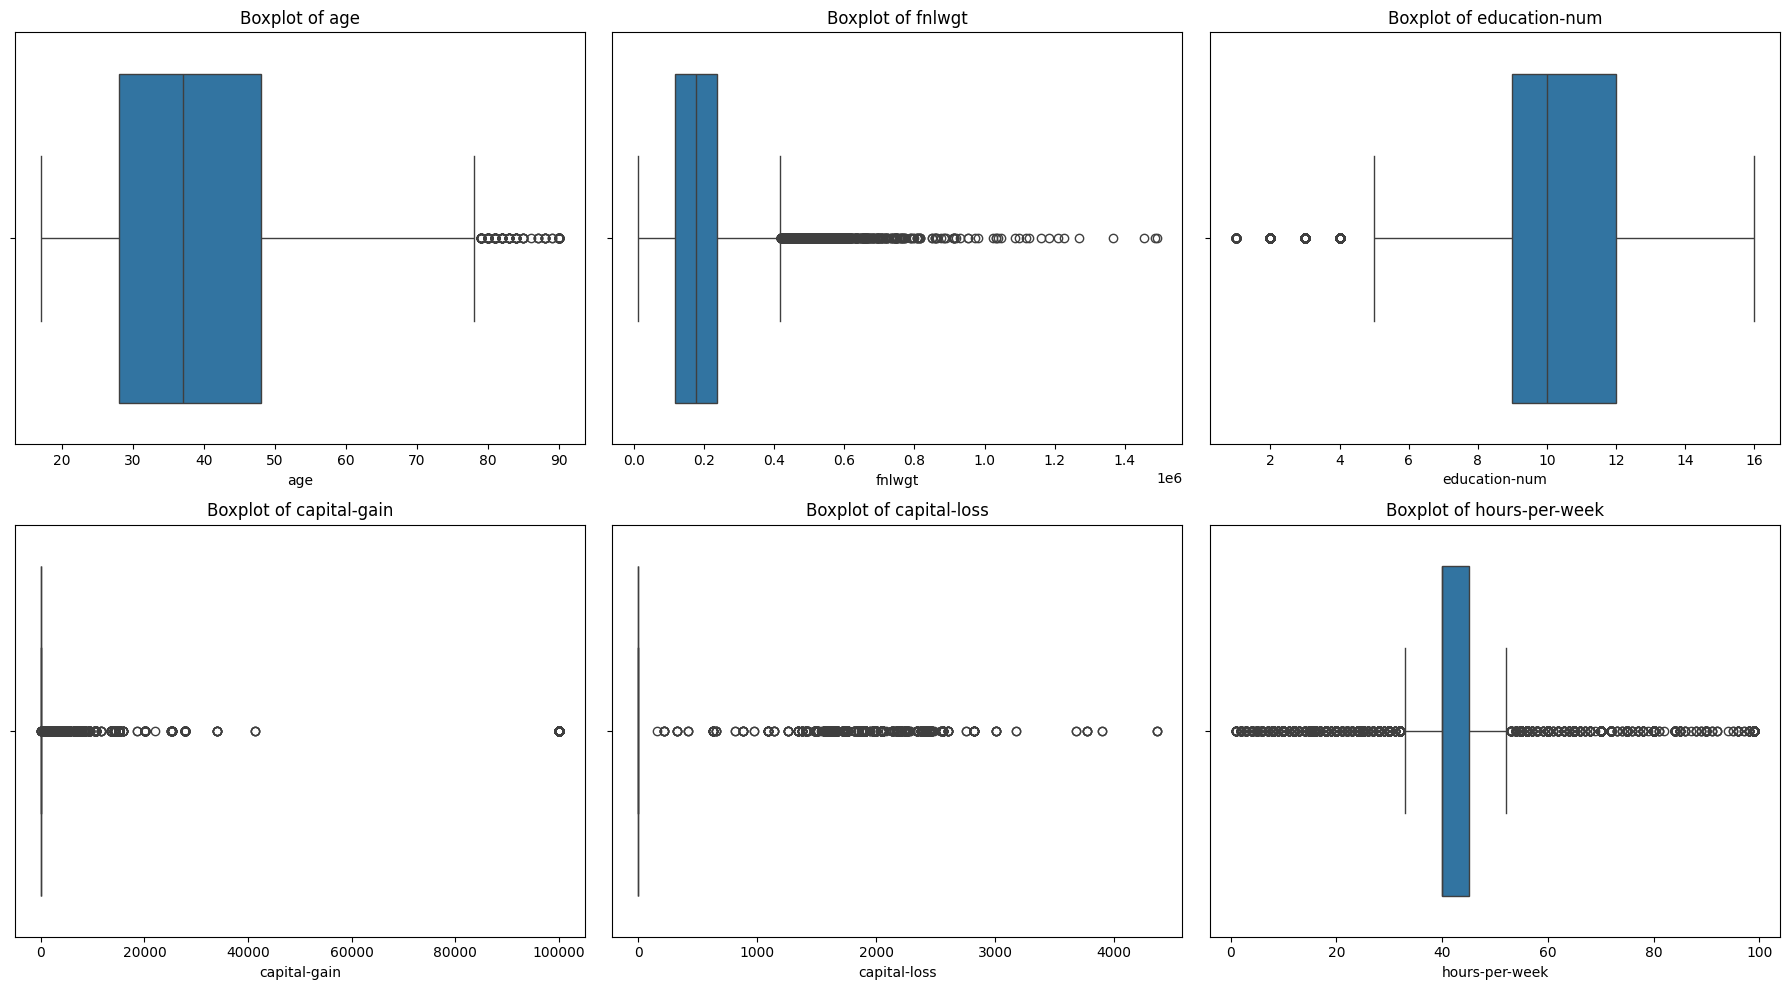

In [ ]:
# Οπτικοποίηση με boxplots των ακραίων τιμών στα αριθμητικά χαρακτηριστικά
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
for ax, col in zip(axes.flatten(), columns):
    sns.boxplot(data=adult, x=col, ax=ax)
    ax.set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [ ]:
# Συνάρτηση για τη μέθοδο IQR και τον εντοπισμό ακραίων τιμών
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25) # 25ο εκατοστημόριο
    Q3 = column.quantile(0.75) # 75ο εκατοστημόριο
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # κάτω όριο
    upper_bound = Q3 + 1.5 * IQR # άνω όριο
    outliers = column[(column < lower_bound) | (column > upper_bound)] # εγγραφές που αντιστοιχούν σε outliers
    return outliers, lower_bound, upper_bound

In [ ]:
# Εκτύπωση αριθμού outliers για κάθε στήλη
for col in ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
    outliers, lower, upper = detect_outliers_iqr(adult[col])
    print(f"Αριθμός ακραίων τιμών στη στήλη {col}: {len(outliers)}")

Αριθμός ακραίων τιμών στη στήλη age: 216
Αριθμός ακραίων τιμών στη στήλη fnlwgt: 1453
Αριθμός ακραίων τιμών στη στήλη education-num: 1794
Αριθμός ακραίων τιμών στη στήλη capital-gain: 4035
Αριθμός ακραίων τιμών στη στήλη capital-loss: 2282
Αριθμός ακραίων τιμών στη στήλη hours-per-week: 13496


In [ ]:
# Εφαρμογή winsorization για τα χαρακτηριστικά fnlwgt και hours-per-week
for col in ['fnlwgt', 'hours-per-week']:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(adult[col])
    adult[col] = np.where(adult[col] < lower_bound, lower_bound, adult[col]) # αντικατάσταση με κάτω όριο
    adult[col] = np.where(adult[col] > upper_bound, upper_bound, adult[col]) # αντικατάσταση με άνω όριο

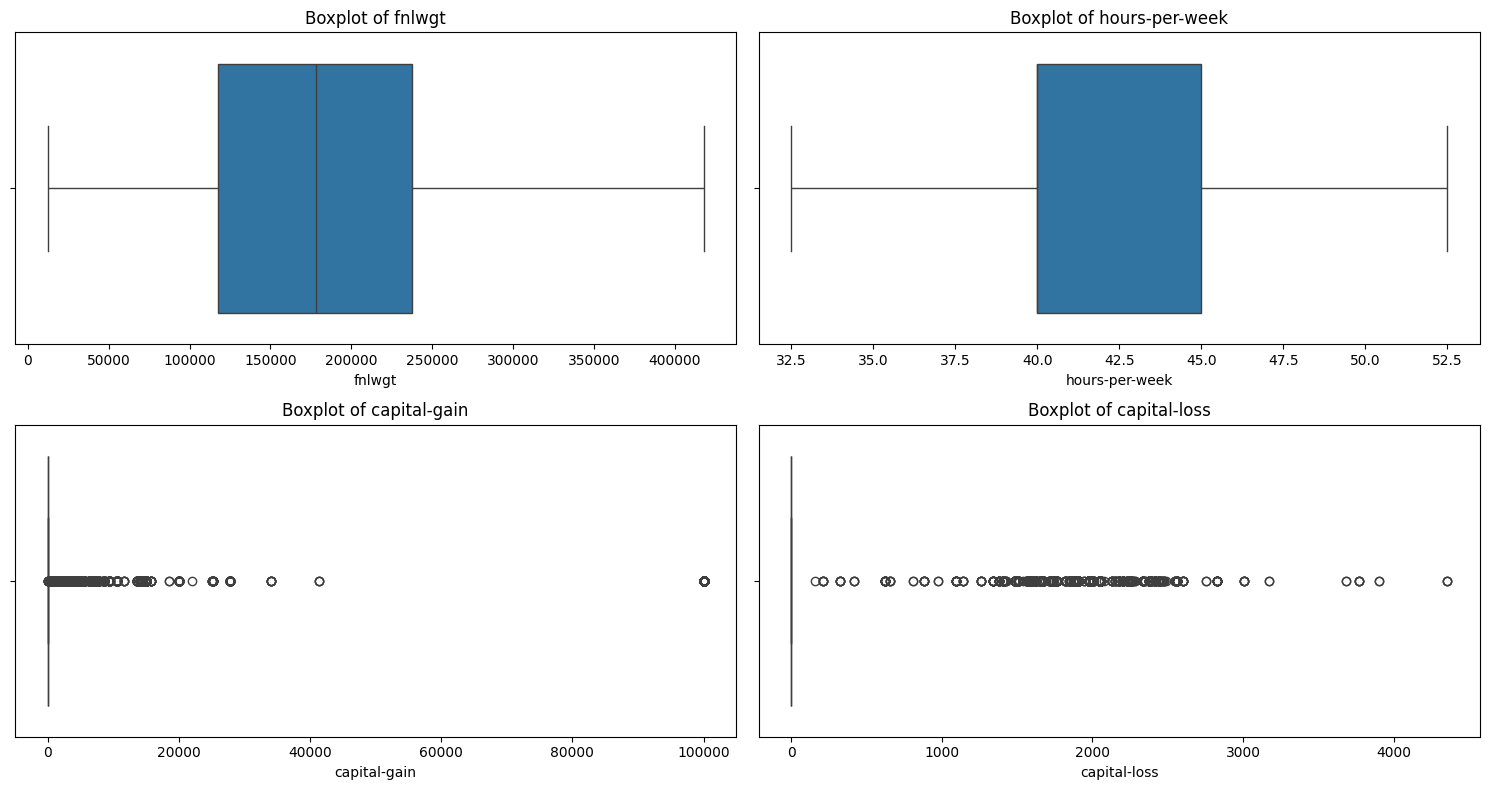

In [ ]:
# Οπτικοποίηση με boxplots για τα χαρακτηριστικά fnlwgt, hours-per-week, capital-gain και capital-loss
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
columns = ["fnlwgt", "hours-per-week", "capital-gain", "capital-loss"]
for ax, col in zip(axes.flatten(), columns):
    sns.boxplot(data=adult, x=col, ax=ax)
    ax.set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [ ]:
# Απομόνωση των μη μηδενικών τιμών για τα χαρακτηριστικά capital-gain και capital-loss
nz_gain = adult.loc[adult["capital-gain"] > 0]
nz_loss = adult.loc[adult["capital-loss"] > 0]

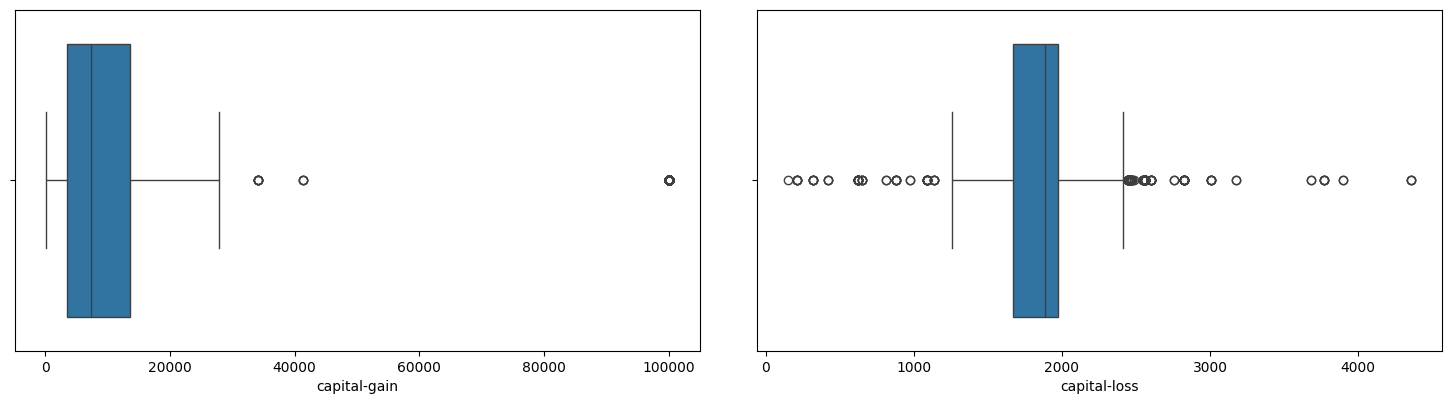

In [ ]:
# Οπτικοποίηση με boxplots για τις μη μηδενικές τιμές των capital-gain και capital-loss
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.tight_layout()
sns.boxplot(data=nz_gain, x=nz_gain["capital-gain"], ax=axes[0])
sns.boxplot(data=nz_loss, x=nz_loss["capital-loss"], ax=axes[1])
plt.show()

In [ ]:
outliers, lower_bound, upper_bound = detect_outliers_iqr(nz_gain["capital-gain"])
print(f"Αριθμός ακραίων τιμών στη στήλη capital-gain: {len(outliers)}")

outliers, lower_bound, upper_bound = detect_outliers_iqr(nz_loss["capital-loss"])
print(f"Αριθμός ακραίων τιμών στη στήλη capital-loss: {len(outliers)}")

Αριθμός ακραίων τιμών στη στήλη capital-gain: 253
Αριθμός ακραίων τιμών στη στήλη capital-loss: 155


In [ ]:
# Ανίχνευση ακραίων τιμών στη στήλη capital-gain με χρήση IQR
outliers, lower_bound, upper_bound = detect_outliers_iqr(nz_gain["capital-gain"])

# Διατρέχουμε όλες τις εγγραφές του dataset
for i in adult.index:
    if adult.loc[i, "capital-gain"] > 0:  # αν η τιμή του capital-gain είναι > 0
        # Αν είναι μικρότερη από το κάτω όριο, την αντικαθιστούμε με το κάτω όριο
        if adult.loc[i, "capital-gain"] < lower_bound:
            adult.loc[i, "capital-gain"] = lower_bound
        # Αν είναι μεγαλύτερη από το άνω όριο, την αντικαθιστούμε με το άνω όριο
        elif adult.loc[i, "capital-gain"] > upper_bound:
            adult.loc[i, "capital-gain"] = upper_bound

In [ ]:
# Η ίδια διαδικασία με παραπάνω, αυτή τη φορά για τη στήλη capital-loss
outliers, lower_bound, upper_bound = detect_outliers_iqr(nz_loss["capital-loss"])

for i in adult.index:
    if adult.loc[i, "capital-loss"] > 0:
        if adult.loc[i, "capital-loss"] < lower_bound:
            adult.loc[i, "capital-loss"] = lower_bound
        elif adult.loc[i, "capital-loss"] > upper_bound:
            adult.loc[i, "capital-loss"] = upper_bound

In [ ]:
adult_preproc = pd.read_csv("adult-preproc.csv") # φόρτωση προεπεξεργασμένου dataset

In [ ]:
scaler = MinMaxScaler() # αρχικοποίηση μοντέλου για κανονικοποίηση στο εύρος [0, 1]

In [ ]:
# Ενημέρωση των στηλών capital-gain και capital-loss
# στο προεπεξεργασμένο dataset, χωρίς τους outliers
for col in ["capital-gain", "capital-loss"]:
    adult_preproc[col] = scaler.fit_transform(adult[[col]])

In [ ]:
adult_preproc.to_csv("adult-preproc.csv", index=False) # αποθήκευση του ενημερωμένου dataset